In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from node2vec import Node2Vec


# Load the CSV file
file_path = "/content/employee_skills_ratings_V3.csv"
data = pd.read_csv(file_path)

# Define the number of rows for the expanded dataset
num_rows = 150

# Create a larger dataset by repeating and shuffling the existing data
expanded_df = data.sample(n=num_rows, replace=True).reset_index(drop=True)

# Add experience columns for various departments
departments = ['DS', 'Marketing', 'Finance', 'HR', 'IT']
for dept in departments:
    col_name = f"{dept}_exp"
    expanded_df[col_name] = np.random.randint(0, 21, size=num_rows)  # Random years of experience from 0 to 20

# Add a Seniority Level column
seniority_levels = ['Lead', 'Senior Analyst', 'Analyst']
expanded_df['Seniority_Level'] = np.random.choice(seniority_levels, size=num_rows)

# Display the first few rows of the expanded dataset to verify the new columns
expanded_df.head()


,Employee ID,Department,ML,DL,Python,Statistics,Data Wrangling,R,Java,C++,...,Excel,Budgeting,Taxation,Investment Analysis,DS_exp,Marketing_exp,Finance_exp,HR_exp,IT_exp,Seniority_Level
0,11,Marketing,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,4,6,8,Senior Analyst
1,82,Human Resources,0,0,0,0,0,0,0,0,...,0,0,0,0,12,20,13,19,3,Lead
2,5,Marketing,0,0,0,0,0,0,0,0,...,0,0,0,0,14,7,17,0,14,Analyst
3,91,Marketing,0,0,0,0,0,0,0,0,...,0,0,0,0,2,12,18,5,6,Analyst
4,103,Data Science,8,7,10,3,1,5,0,0,...,0,0,0,0,12,1,8,14,18,Lead


In [2]:
# !pip install node2vec

*****************************************
Data Science
{'ML': 5, 'DL': 5, 'Python': 4, 'Statistics': 4}
18
skill_weight * skill_score + seniority_weight * experience_score
0.7 0.6111111111111112 0.3 0
*****************************************
Marketing
{'SEO': 5, 'Content Creation': 4, 'Social Media': 5}
14
skill_weight * skill_score + seniority_weight * experience_score
0.7 0.2857142857142857 0.3 0.3
*****************************************
Finance
{'Accounting': 5, 'Financial Analysis': 5, 'Excel': 4}
14
skill_weight * skill_score + seniority_weight * experience_score
0.7 0.0 0.3 0.2
*****************************************
HR
{'Recruitment': 5, 'Training': 4, 'Communication': 4}
13
skill_weight * skill_score + seniority_weight * experience_score
0.7 0.0 0.3 0.0
*****************************************
IT
{'Java': 5, 'C++': 4, 'Data Structures': 5}
14
skill_weight * skill_score + seniority_weight * experience_score
0.7 0.21428571428571427 0.3 0.1
Best Department: Data Science
Fit 

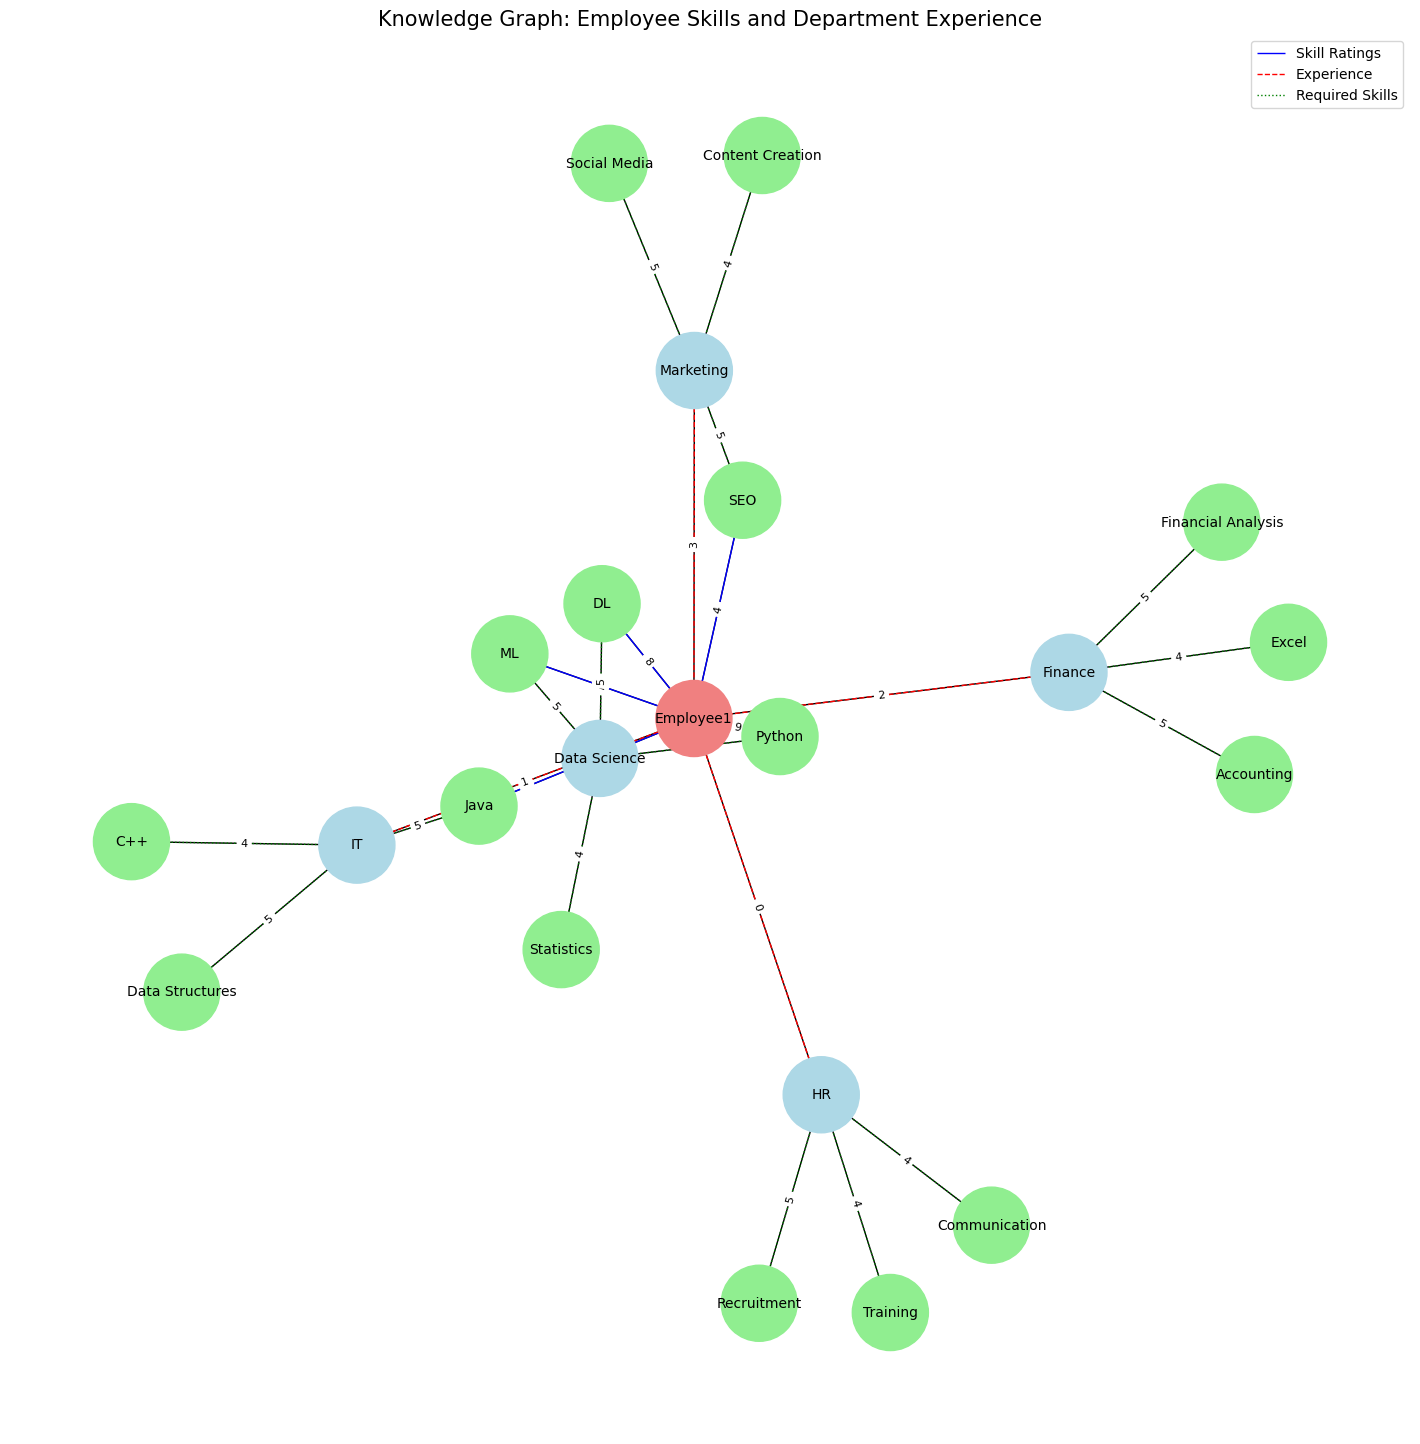

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def build_knowledge_graph(departments_skills, employee):
    G = nx.Graph()

    # Add department nodes and their skills with required ratings
    for dept, skills in departments_skills.items():
        G.add_node(dept, type='Department')
        for skill, required_rating in skills.items():
            G.add_node(skill, type='Skill')
            G.add_edge(dept, skill, required_rating=required_rating, type='RequiredSkill')

    # Add employee node
    G.add_node(employee['name'], type='Employee')

    # Add edges for the employee's skills and their ratings
    for skill, rating in employee['skills'].items():
        if G.has_node(skill):
            G.add_edge(employee['name'], skill, rating=rating, type='Skill')

    # Add edges for the employee's experience in departments
    for dept in departments_skills.keys():
        dept_exp_key = f"{dept}_exp"
        if dept_exp_key in employee['experience']:
            G.add_edge(employee['name'], dept, experience=employee['experience'][dept_exp_key], type='Experience')

    return G

def evaluate_fit_with_graph(G, department_skills, candidate_node='Candidate'):
    best_department = None
    best_match_score = float('-inf')
    best_fit_details = {}

    # Weights for skills and seniority
    skill_weight = 0.7
    seniority_weight = 0.3

    for department in [n for n, d in G.nodes(data=True) if d['type'] == 'Department']:
        matching_skills = {}
        missing_skills = {}
        skills_to_improve = {}

        # Get the skills required by the department
        required_skills = {neighbor: G.edges[department, neighbor]['required_rating']
                           for neighbor in G.neighbors(department) if G.nodes[neighbor]['type'] == 'Skill'}
        print("*****************************************")
        print(department)
        print(required_skills)

        # Skill matching score
        skill_score = 0
        total_required_rating = sum(required_skills.values())
        print(total_required_rating)
        for skill, required_rating in required_skills.items():
            if G.has_edge(candidate_node, skill) and G.edges[candidate_node, skill]['type'] == 'Skill':
                candidate_rating = G.edges[candidate_node, skill]['rating']
                if candidate_rating >= required_rating:
                    matching_skills[skill] = candidate_rating
                    skill_score += required_rating  # Fully matches required skill
                else:
                    skills_to_improve[skill] = (candidate_rating, required_rating)
                    skill_score += candidate_rating  # Partially matches skill
            else:
                missing_skills[skill] = required_rating

        # Normalize skill score by the total required rating
        if total_required_rating > 0:
            skill_score /= total_required_rating

        # Experience score based on seniority
        experience_score = 0
        if G.has_edge(candidate_node, department) and G.edges[candidate_node, department]['type'] == 'Experience':
            experience_years = G.edges[candidate_node, department]['experience']
            experience_score = min(experience_years / 10, 1)  # Normalize to a maximum of 1

        # Calculate the combined match score
        print("skill_weight * skill_score + seniority_weight * experience_score")
        print(skill_weight, skill_score , seniority_weight ,experience_score)
        match_score = skill_weight * skill_score + seniority_weight * experience_score

        if match_score > best_match_score:
            best_match_score = match_score
            best_department = department
            best_fit_details = {
                "matching_skills": matching_skills,
                "missing_skills": missing_skills,
                "skills_to_improve": skills_to_improve,
                "skill_score": skill_score,
                "experience_score": experience_score
            }

    return best_department, best_fit_details

def predict_seniority_level(employee, department_skills, department):
    # Simplified heuristic for seniority level:
    total_experience_years = employee['experience'].get(f"{department}_exp", 0)

    # Heuristic based on experience in years
    if total_experience_years >= 10:
        return 'Lead'
    elif total_experience_years >= 5:
        return 'Senior Analyst'
    else:
        return 'Analyst'

def visualize_knowledge_graph(G):
    pos = nx.spring_layout(G)
    color_map = {'Department': 'lightblue', 'Skill': 'lightgreen', 'Employee': 'lightcoral'}

    node_colors = [color_map[G.nodes[node]['type']] for node in G.nodes]

    # Draw nodes
    plt.figure(figsize=(14, 14))
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=3000, font_size=10)

    # Draw edges with different styles for skills and experience
    edge_labels = nx.get_edge_attributes(G, 'rating')
    edge_labels.update(nx.get_edge_attributes(G, 'required_rating'))
    edge_labels.update(nx.get_edge_attributes(G, 'experience'))

    skill_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'Skill']
    exp_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'Experience']
    required_skill_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'RequiredSkill']

    nx.draw_networkx_edges(G, pos, edgelist=skill_edges, edge_color='blue', style='solid', label='Skill Ratings')
    nx.draw_networkx_edges(G, pos, edgelist=exp_edges, edge_color='red', style='dashed', label='Experience')
    nx.draw_networkx_edges(G, pos, edgelist=required_skill_edges, edge_color='green', style='dotted', label='Required Skills')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Knowledge Graph: Employee Skills and Department Experience", size=15)
    plt.legend()
    plt.show()

# Example data
departments_skills = {
    'Data Science': {'ML': 5, 'DL': 5, 'Python': 4, 'Statistics': 4},
    'Marketing': {'SEO': 5, 'Content Creation': 4, 'Social Media': 5},
    'Finance': {'Accounting': 5, 'Financial Analysis': 5, 'Excel': 4},
    'HR': {'Recruitment': 5, 'Training': 4, 'Communication': 4},
    'IT': {'Java': 5, 'C++': 4, 'Data Structures': 5}
}

employee = {
    'name': 'Employee1',
    'skills': {'ML': 2, 'DL': 8, 'Python': 9, 'SEO': 4, 'Java': 3},
    'experience': {'DS_exp': 5, 'Marketing_exp': 3, 'Finance_exp': 2, 'HR_exp': 0, 'IT_exp': 1}
}

# Build the graph
G = build_knowledge_graph(departments_skills, employee)

# Evaluate fit and get recommendations
best_department, fit_details = evaluate_fit_with_graph(G, departments_skills, candidate_node=employee['name'])

# Predict the seniority level
seniority_level = predict_seniority_level(employee, departments_skills, best_department)

# Print the results
print("Best Department:", best_department)
print("Fit Details:", fit_details)
print("Recommended Seniority Level:", seniority_level)

# Visualize the Knowledge Graph
visualize_knowledge_graph(G)


In [19]:
# Sample data similar to the knowledge graph data
departments_skills = {
    'Data Science': {'ML': 5, 'DL': 5, 'Python': 4, 'Statistics': 4},
    'Marketing': {'SEO': 5, 'Content Creation': 4, 'Social Media': 5},
    'Finance': {'Accounting': 5, 'Financial Analysis': 5, 'Excel': 4},
    'HR': {'Recruitment': 5, 'Training': 4, 'Communication': 4},
    'IT': {'Java': 5, 'C++': 4, 'Data Structures': 5}
}

employee = {
    'name': 'Employee1',
    'skills': {'ML': 2, 'DL': 8, 'Python': 9, 'SEO': 4, 'Java': 3},
    'experience': {'DS_exp': 5, 'Marketing_exp': 3, 'Finance_exp': 2, 'HR_exp': 0, 'IT_exp': 1}
}

def evaluate_fit_without_graph(departments_skills, employee):
    best_department = None
    best_match_score = float('-inf')
    best_fit_details = {}

    # Weights for skills and seniority
    skill_weight = 0.7
    seniority_weight = 0.3

    for department, skills in departments_skills.items():
        matching_skills = {}
        missing_skills = {}
        skills_to_improve = {}

        # Calculate skill matching score
        skill_score = 0
        total_required_rating = sum(skills.values())
        for skill, required_rating in skills.items():
            if skill in employee['skills']:
                candidate_rating = employee['skills'][skill]
                if candidate_rating >= required_rating:
                    matching_skills[skill] = candidate_rating
                    skill_score += required_rating  # Fully matches required skill
                else:
                    skills_to_improve[skill] = (candidate_rating, required_rating)
                    skill_score += candidate_rating  # Partially matches skill
            else:
                missing_skills[skill] = required_rating

        # Normalize skill score by the total required rating
        if total_required_rating > 0:
            skill_score /= total_required_rating

        # Experience score based on seniority
        dept_exp_key = f"{department.split(' ')[0]}_exp"  # Simplified experience key matching
        experience_score = min(employee['experience'].get(dept_exp_key, 0) / 10, 1)  # Normalize to a maximum of 1

        # Calculate the combined match score
        match_score = skill_weight * skill_score + seniority_weight * experience_score

        if match_score > best_match_score:
            best_match_score = match_score
            best_department = department
            best_fit_details = {
                "matching_skills": matching_skills,
                "missing_skills": missing_skills,
                "skills_to_improve": skills_to_improve,
                "skill_score": skill_score,
                "experience_score": experience_score
            }

    return best_department, best_fit_details

def predict_seniority_level(employee, department):
    total_experience_years = employee['experience'].get(f"{department.split(' ')[0]}_exp", 0)

    # Heuristic based on experience in years
    if total_experience_years >= 10:
        return 'Lead'
    elif total_experience_years >= 5:
        return 'Senior Analyst'
    else:
        return 'Analyst'

# Evaluate fit and get recommendations
best_department, fit_details = evaluate_fit_without_graph(departments_skills, employee)

# Predict the seniority level
seniority_level = predict_seniority_level(employee, best_department)

# Print the results
print("Best Department:", best_department)
print("Fit Details:", fit_details)
print("Recommended Seniority Level:", seniority_level)


Best Department: Data Science
Fit Details: {'matching_skills': {'DL': 8, 'Python': 9}, 'missing_skills': {'Statistics': 4}, 'skills_to_improve': {'ML': (2, 5)}, 'skill_score': 0.6111111111111112, 'experience_score': 0.0}
Recommended Seniority Level: Analyst


**Comparison: Knowledge Graph vs. Non-Knowledge Graph Approach**


**Knowledge Graph Approach:**

***Pros***:

1. Scalability: Easier to scale with complex relationships and more entities (departments, skills, employees).
2. Flexibility: Can represent various types of relationships and attributes easily.
3. Visualization: Provides a visual representation of relationships which can be insightful.
4. Advanced Queries: Enables complex queries and analytics on the relationships (e.g., pathfinding, community detection).

***Cons:***

1. Complexity: More complex to implement and understand, especially for simpler problems.
2. Performance: May be less performant for simple lookups compared to direct dictionary operations.

**Non-Knowledge Graph Approach:**

***Pros***:

1. Simplicity: Easier to implement and understand for straightforward relationships.
2. Performance: Generally faster for basic operations and lookups in small datasets.
3. Low Overhead: No need for additional libraries or frameworks.

***Cons***:

1. Scalability: Harder to manage and extend with complex or evolving relationships.
2. Flexibility: Less flexible in representing complex interactions and attributes.
3. Visualization: Lacks the inherent ability to visualize relationships.

Conclusion
Use the Knowledge Graph Approach if you need to manage and analyze complex, evolving relationships and benefit from visualizing these relationships.
Use the Non-Knowledge Graph Approach if your problem is straightforward with simple relationships, where performance and simplicity are key considerations.

For the given problem, both approaches are feasible. The choice depends on the complexity of the data and the need for scalability or visualization.

Best Department: Data Science
Fit Details: {'matching_skills': {'DL': 8, 'Python': 9}, 'missing_skills': {'Statistics': 4}, 'skills_to_improve': {'ML': (2, 5)}, 'skill_score': 0.6111111111111112, 'experience_score': 0.5}
Recommended Seniority Level: Senior Analyst


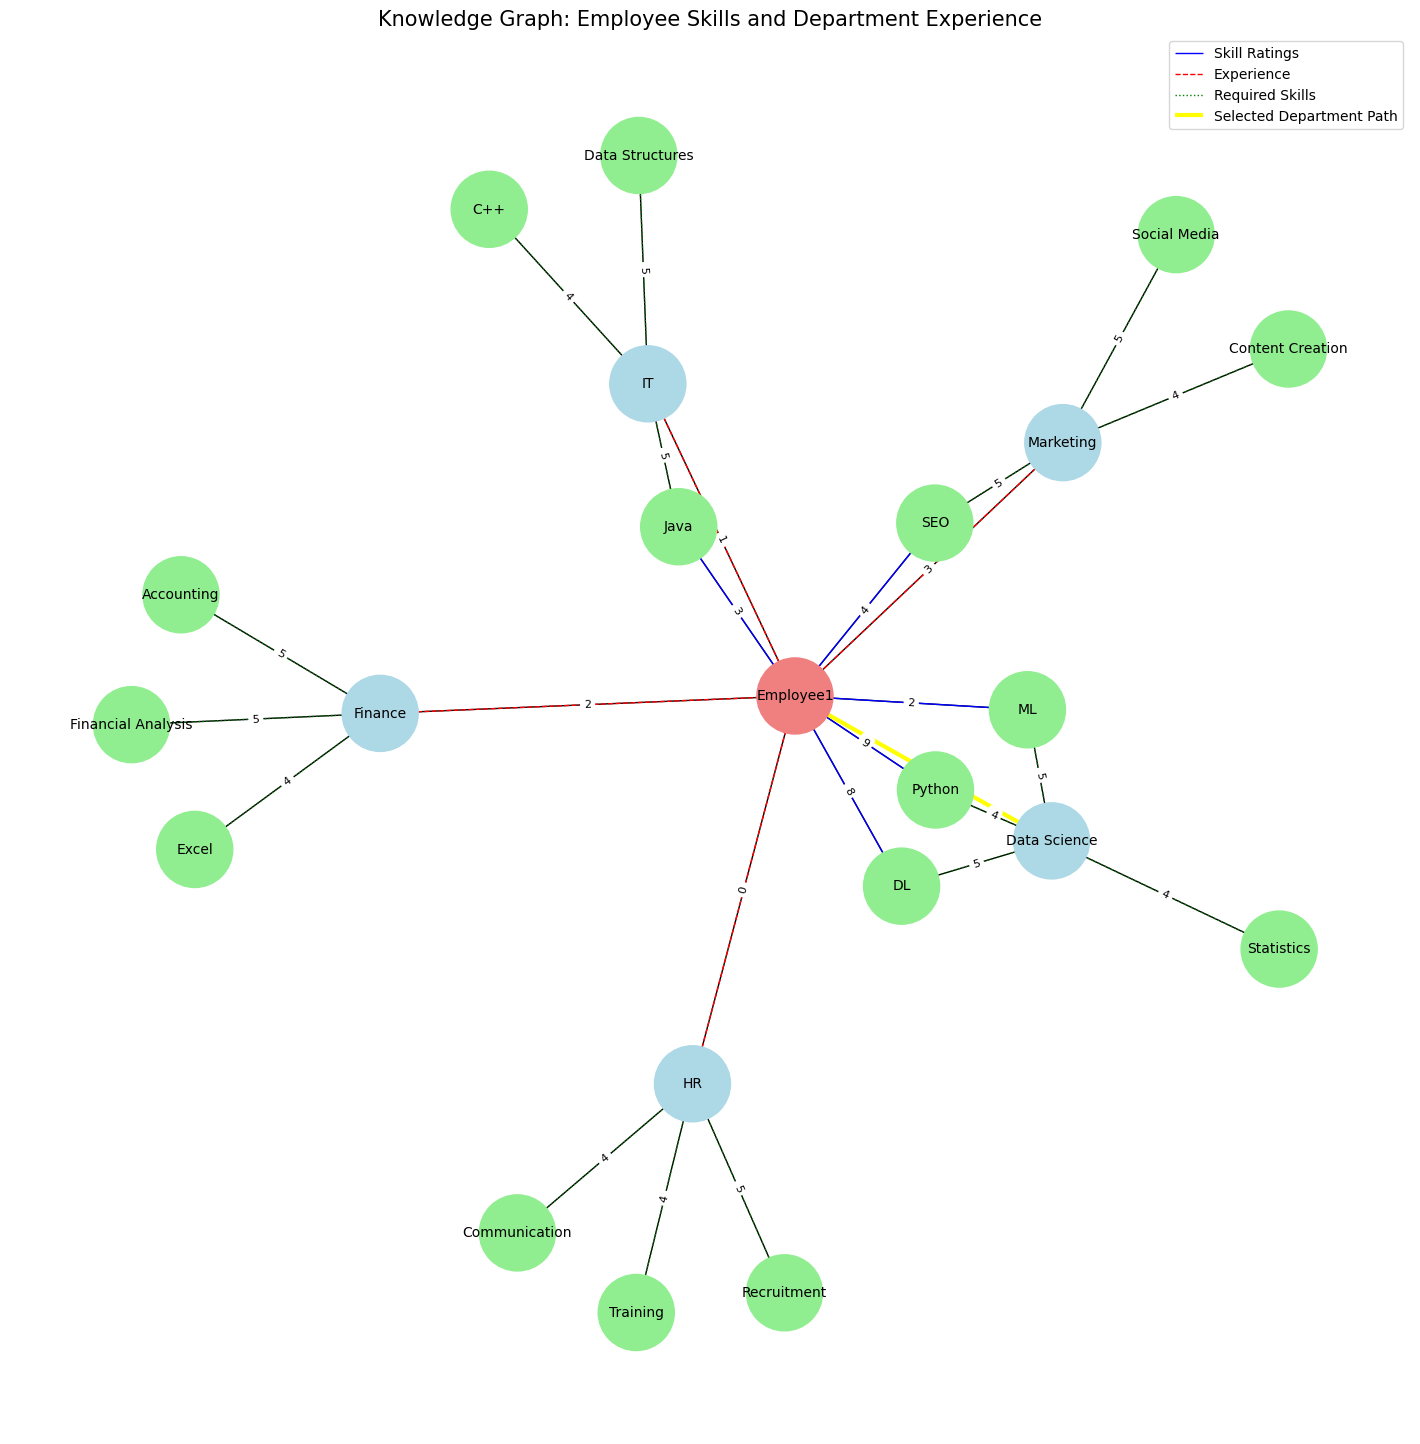

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

def build_knowledge_graph(departments_skills, employee):
    G = nx.Graph()

    # Add department nodes and their skills with required ratings
    for dept, skills in departments_skills.items():
        G.add_node(dept, type='Department')
        for skill, required_rating in skills.items():
            G.add_node(skill, type='Skill')
            G.add_edge(dept, skill, required_rating=required_rating, type='RequiredSkill')

    # Add employee node
    G.add_node(employee['name'], type='Employee')

    # Add edges for the employee's skills and their ratings
    for skill, rating in employee['skills'].items():
        if G.has_node(skill):
            G.add_edge(employee['name'], skill, rating=rating, type='Skill')

    # Add edges for the employee's experience in departments
    for dept in departments_skills.keys():
        dept_exp_key = f"{dept}_exp"
        if dept_exp_key in employee['experience']:
            G.add_edge(employee['name'], dept, experience=employee['experience'][dept_exp_key], type='Experience')

    return G

def evaluate_fit_with_graph(G, department_skills, candidate_node='Candidate'):
    best_department = None
    best_match_score = float('-inf')
    best_fit_details = {}

    # Weights for skills and seniority
    skill_weight = 0.7
    seniority_weight = 0.3

    for department in [n for n, d in G.nodes(data=True) if d['type'] == 'Department']:
        matching_skills = {}
        missing_skills = {}
        skills_to_improve = {}

        # Get the skills required by the department
        required_skills = {neighbor: G.edges[department, neighbor]['required_rating']
                           for neighbor in G.neighbors(department) if G.nodes[neighbor]['type'] == 'Skill'}

        # Skill matching score
        skill_score = 0
        total_required_rating = sum(required_skills.values())
        for skill, required_rating in required_skills.items():
            if G.has_edge(candidate_node, skill) and G.edges[candidate_node, skill]['type'] == 'Skill':
                candidate_rating = G.edges[candidate_node, skill]['rating']
                if candidate_rating >= required_rating:
                    matching_skills[skill] = candidate_rating
                    skill_score += required_rating  # Fully matches required skill
                else:
                    skills_to_improve[skill] = (candidate_rating, required_rating)
                    skill_score += candidate_rating  # Partially matches skill
            else:
                missing_skills[skill] = required_rating

        # Normalize skill score by the total required rating
        if total_required_rating > 0:
            skill_score /= total_required_rating

        # Experience score based on seniority
        experience_score = 0
        if G.has_edge(candidate_node, department) and G.edges[candidate_node, department]['type'] == 'Experience':
            experience_years = G.edges[candidate_node, department]['experience']
            experience_score = min(experience_years / 10, 1)  # Normalize to a maximum of 1

        # Calculate the combined match score
        match_score = skill_weight * skill_score + seniority_weight * experience_score

        if match_score > best_match_score:
            best_match_score = match_score
            best_department = department
            best_fit_details = {
                "matching_skills": matching_skills,
                "missing_skills": missing_skills,
                "skills_to_improve": skills_to_improve,
                "skill_score": skill_score,
                "experience_score": experience_score
            }

    return best_department, best_fit_details

def predict_seniority_level(employee, department_skills, department):
    # Simplified heuristic for seniority level:
    total_experience_years = employee['experience'].get(f"{department}_exp", 0)

    # Heuristic based on experience in years
    if total_experience_years >= 10:
        return 'Lead'
    elif total_experience_years >= 5:
        return 'Senior Analyst'
    else:
        return 'Analyst'

def visualize_knowledge_graph(G, selected_department):
    pos = nx.spring_layout(G)
    color_map = {'Department': 'lightblue', 'Skill': 'lightgreen', 'Employee': 'lightcoral'}

    node_colors = [color_map[G.nodes[node]['type']] for node in G.nodes]

    # Draw nodes
    plt.figure(figsize=(14, 14))
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=3000, font_size=10)

    # Draw edges with different styles for skills and experience
    edge_labels = nx.get_edge_attributes(G, 'rating')
    edge_labels.update(nx.get_edge_attributes(G, 'required_rating'))
    edge_labels.update(nx.get_edge_attributes(G, 'experience'))

    skill_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'Skill']
    exp_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'Experience']
    required_skill_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'RequiredSkill']

    nx.draw_networkx_edges(G, pos, edgelist=skill_edges, edge_color='blue', style='solid', label='Skill Ratings')
    nx.draw_networkx_edges(G, pos, edgelist=exp_edges, edge_color='red', style='dashed', label='Experience')
    nx.draw_networkx_edges(G, pos, edgelist=required_skill_edges, edge_color='green', style='dotted', label='Required Skills')

    # Highlight the path to the selected department
    path_edges = nx.shortest_path(G, source=employee['name'], target=selected_department)
    path_edges = list(zip(path_edges, path_edges[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='yellow', width=3, style='solid', label='Selected Department Path')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Knowledge Graph: Employee Skills and Department Experience", size=15)
    plt.legend()
    plt.show()

# Example data
departments_skills = {
    'Data Science': {'ML': 5, 'DL': 5, 'Python': 4, 'Statistics': 4},
    'Marketing': {'SEO': 5, 'Content Creation': 4, 'Social Media': 5},
    'Finance': {'Accounting': 5, 'Financial Analysis': 5, 'Excel': 4},
    'HR': {'Recruitment': 5, 'Training': 4, 'Communication': 4},
    'IT': {'Java': 5, 'C++': 4, 'Data Structures': 5}
}

employee = {
    'name': 'Employee1',
    'skills': {'ML': 2, 'DL': 8, 'Python': 9, 'SEO': 4, 'Java': 3},
    'experience': {'Data Science_exp': 5, 'Marketing_exp': 3, 'Finance_exp': 2, 'HR_exp': 0, 'IT_exp': 1}
}

# Build the graph
G = build_knowledge_graph(departments_skills, employee)

# Evaluate fit and get recommendations
best_department, fit_details = evaluate_fit_with_graph(G, departments_skills, candidate_node=employee['name'])

# Predict the seniority level
seniority_level = predict_seniority_level(employee, departments_skills, best_department)

# Print the results
print("Best Department:", best_department)
print("Fit Details:", fit_details)
print("Recommended Seniority Level:", seniority_level)

# Visualize the Knowledge Graph with selected department path highlighted
visualize_knowledge_graph(G, best_department)
